In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append('/home/intern_lhj/researches/retinal_atherosclerosis')

In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import math

# https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/activations_and_gradients.py

In [11]:
a = Image.open('n03481172_hammer.JPEG')
b = Image.open('n07920052_espresso.JPEG')

image_size = 224
valid_transform = []
valid_transform.append(
    torchvision.transforms.Resize(image_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC), 
)
valid_transform.append(torchvision.transforms.CenterCrop(image_size))
valid_transform.append(torchvision.transforms.ToTensor())
valid_transform.append(torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)))
valid_transform = torchvision.transforms.Compose(valid_transform)

inputs = torch.stack([
    valid_transform(a),
    valid_transform(b)
]).cuda()
inputs.shape
# inputs.requires_grad = True

torch.Size([2, 3, 224, 224])

In [2]:
# model = torchvision.models.vit_b_16('IMAGENET1K_V1').cuda()
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').cuda()

In [9]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.model.cuda()
        self.target_layer = target_layer
        self.register_hooks()

    def get_activation(self, module, input, output):
        self.activation = output.cpu().detach()

    def get_gradient(self, module, input, output):
        def _store_gradient(grad):
            self.gradient = grad.cpu().detach()
        output.register_hook(_store_gradient)

    def register_hooks(self):
        self.hooks = [
            self.target_layer.register_forward_hook(self.get_activation),
            self.target_layer.register_forward_hook(self.get_gradient)
        ]
    def release_hooks(self):
        for h in self.hooks:
            h.remove()
        
    @torch.enable_grad()
    def forward(self, inputs):

        self.model.zero_grad()
        output = model(inputs)
        # pred = output.max(dim = 1).values.sum()
        pred = output.logits.max(dim = 1).values.sum()
        pred.backward()



    def vit_transform(self, tensor):
        batch, hw, c = tensor.shape
        h = w = int(math.sqrt(hw - 1))
        embeddings = tensor[:, 1:, :].reshape(batch, h, w, c)
        return embeddings.permute([0, 3, 1, 2])


    def compute_gradcam(self, inputs, size = (224, 224)):
        self.inputs = inputs
        self.forward(inputs)
        activation = self.vit_transform(self.activation)

        gradient = self.vit_transform(self.gradient)
        weights = gradient.view(gradient.shape[0], gradient.shape[1], -1).mean(dim = 2)

        gradcam = (weights[:, :, None, None] * activation).sum(1, keepdims = True)
        gradcam = F.relu(gradcam)
        saliency_map = F.interpolate(gradcam, size = size, mode = 'bilinear').squeeze(dim=1)
        saliency_map /= saliency_map.max()

        return saliency_map.cpu().detach()

    def inverse_norm(self, inputs = None, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
        if inputs:
            self.inputs = inputs
        inverse = torchvision.transforms.Normalize(
            mean=[-m / s for m, s in zip(mean, std)],
            std=[1 / s for s in std]
        )
        return inverse(self.inputs).cpu().detach().permute(0,2,3,1)
        

CAM = GradCAM(
    model = model,
    # target_layer = model.encoder.layers.encoder_layer_11.ln_1
    target_layer = model.vit.encoder.layer[-1].layernorm_before
)



In [12]:
saliency_map = CAM.compute_gradcam(inputs)
images = CAM.inverse_norm()

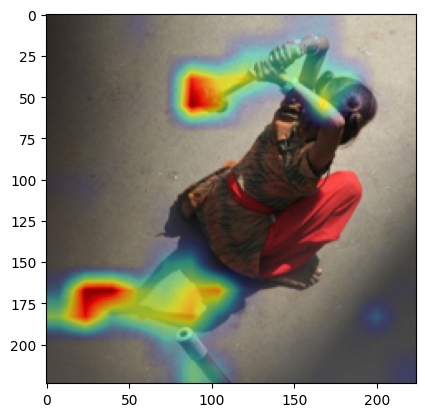

In [14]:
plt.imshow(images[0])
plt.imshow(saliency_map[0], cmap = 'jet', alpha = saliency_map[0])